<a href="https://colab.research.google.com/github/wantepim84/NetworkX/blob/main/NetworkX_Ch11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

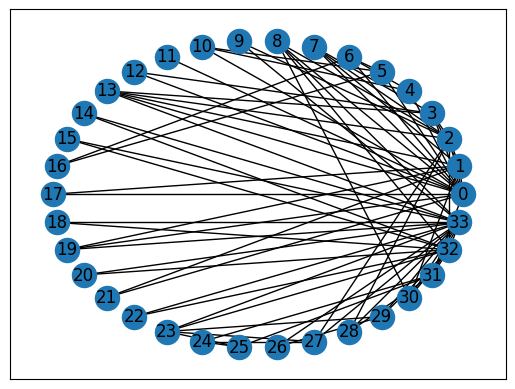

In [ ]:
# The circular layout - Visualisation
G_karate = nx.karate_club_graph()
nx.draw_networkx(G_karate, pos=nx.circular_layout(G_karate))

In [ ]:
# Reordering the nodes to group them by community
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

import networkx.algorithms.community as nxcom
def community_net(G_in):
    G_out = nx.Graph()
    node_color = []
    node_community = {}
    communities = nxcom.greedy_modularity_communities(G_in)
    for i, com in enumerate(communities):
        for v in com:
            G_out.add_node(v)
            node_color.append(get_color(i))
            node_community[v] = i
    G_out.add_edges_from(G_in.edges())
    return node_color, node_community, G_out

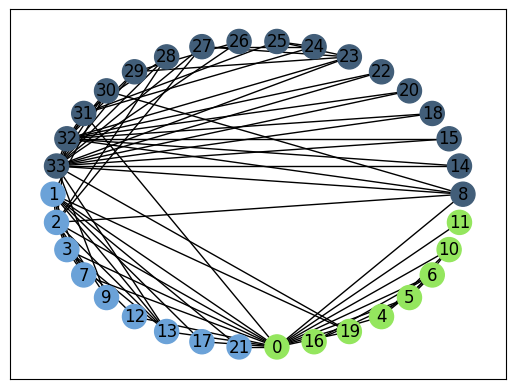

In [ ]:
node_color, node_community, G = community_net(G_karate)
nx.draw_networkx(G, pos=nx.circular_layout(G), node_color=node_color)

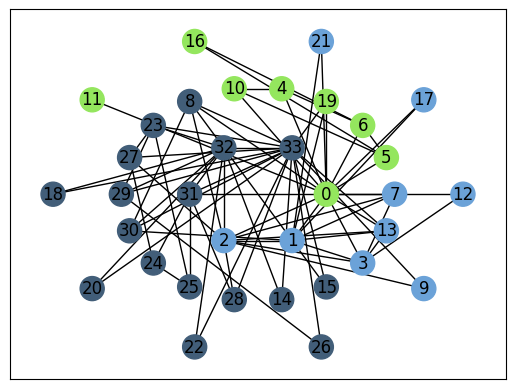

In [ ]:
# Shell Layout
# community detection to place related nodes in similar locations
degrees = dict(G.degree())
labels = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)
nlist = []
i, k = 0, 6
while i < len(labels):
    shell_labels = labels[i:i+k]
    ordered_labels = sorted(shell_labels, key=lambda x: node_community[x])
    nlist.append(ordered_labels)
    i += k
    k += 12
pos = nx.shell_layout(G, nlist=nlist)
cm = plt.get_cmap('cool')
nx.draw_networkx(
    G, pos, alpha=1, node_color=node_color, with_labels=True)

In [11]:
# Null models
# Create data directory path
from pathlib import Path
data_dir = Path('/content/frankenstein.txt')

In [12]:
# Ignore articles, pronouns, etc.
stop_words = set([
    'the', 'of', 'and', 'i', 'to', 'my', 'in', 'was', 'that', 'thy',
    'a', 'had', 'my', 'with', 'but', 'he', 'she', 'you', 'your',
    'me', 'not', 'as', 'will', 'from', 'on', 'be', 'it', 'which',
    'for', 'his', 'him', 'chapter', 'at', 'who', 'by', 'have',
    'would', 'is', 'been', 'when', 'they', 'there', 'we', 'are',
    'our', 'if', 'her', 'were', 'than', 'this', 'what', 'so',
    'yet', 'more', 'their', 'them', 'or', 'could', 'an', 'can',
    'said', 'may', 'do', 'these', 'shall', 'how', 'shall', 'asked',
    'before', 'those', 'whom', 'am', 'even', 'its', 'did', 'then',
    'abbey', 'tintern', 'wordsworth', 'letter', 'thee', 'thou', 'oh',
    'into', 'any', 'myself', 'nor', 'himself', 'one', 'all', 'no', 'yes'
    'now', 'upon', 'only', 'might', 'every', 'own', 'such', 'towards',
    'again', 'most', 'ever', 'where', 'after', 'up', 'soon', 'many',
    'also', 'like', 'over', 'us', 'thus', 'has', 'about']
    + [str(x) for x in range(24)])

In [13]:
# This example uses regular expressions from the re package
import re
# Construct a network from a text
def co_occurrence_network(text):
    # Create a new network
    G = nx.Graph()
    # Split the text into sentences and iterate through them
    sentences = text.split('.')
    for s in sentences:
        # Remove punctuation and convert to lowercase
        clean = re.sub('[^\w\n ]+', '', s).lower()
        clean = re.sub('_+', '', clean).strip()
        # Create list of words separated by whitespace
        words = re.split('\s+', clean)
        # Create an edge for each pair of words
        for v in words:
            # Update word count, add node if necessary
            try:
                G.nodes[v]['count'] += 1
            except KeyError:
                G.add_node(v)
                G.nodes[v]['count'] = 1
            # Update edge count for each pair of words in this sentence
            for w in words:
                # Skip stop words
                if v == w or v in stop_words or w in stop_words:
                    continue
                # Skip blank space
                if len(v) == 0 or len(w) == 0:
                    continue
                # Add one to the edge's count
                try:
                    G.edges[v, w]['count'] += 1
                except KeyError:
                    # Edge doesn't exist, create it
                    G.add_edge(v, w, count=1)
    return G

In [15]:
# Read the text
with open(data_dir) as f:
    text = f.read()
# Create a network from the text
G_frank = co_occurrence_network(text)

In [16]:
# Forced direct layout
# Count co-occurrences for frankenstein node
focus = 'monster'
neighbors = list(G_frank.neighbors(focus))
counts = dict(
    (v, G_frank.edges[(focus, v)]['count'])
    for v in neighbors)
# Limit network to focus and neighbors
nodes = neighbors + [focus]
G_focus = G_frank.subgraph(nodes)

In [17]:
import math
def residual_net(G):
    G_residual = nx.Graph(G)
    # Calculate weighted degrees
    degrees = dict((v, 0) for v in G_residual.nodes)
    for e in G_residual.edges:
        v, w = e
        degrees[v] += G_residual.edges[e]['count']
        degrees[w] += G_residual.edges[e]['count']
    # Calculate total edge weight in network
    M = sum([G_residual.edges[e]['count'] for e in G_residual.edges])
    # Find residual weight for each node pair
    for v in G_residual.nodes:
        for w in G_residual.nodes:
            dv = degrees[v]
            dw = degrees[w]
            # Only count each edge once
            if v >= w:
                continue
            # Expected fraction of weights associated with each endpoint
            # Factor of two adjusts normalization for excuding v >= w
            expected = (dv / M / 2) * (dw / M / 2) * 2 * M
            if expected == 0:
                continue
            try:
                count = G_residual.edges[v, w]['count']
                log_residual = math.log10(count) - math.log10(expected)
                G_residual.edges[v, w]['log_residual'] = log_residual
            except KeyError:
                continue
    return G_residual

In [18]:
# Generate residual network
G_residual = residual_net(G_frank)

In [19]:
# Find edges with residuals above a threshold
threshold = 3.2
edges = [
    (v, w) for v, w, d in G_residual.edges(data=True)
    if d['log_residual'] > threshold]
# Create a network with only those edges
G_threshold = G_residual.edge_subgraph(edges)
# Find largest connected component
G_giant = G_threshold.subgraph(max(nx.connected_components(G_threshold), key=len))

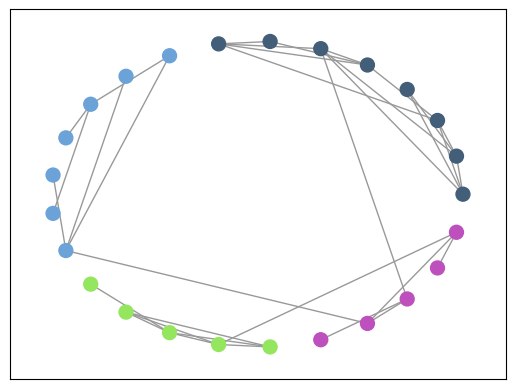

In [20]:
# Find communities
G = G_giant
node_color, node_community, G = community_net(G)
pos = nx.circular_layout(G)
nx.draw_networkx(
    G, pos=pos, node_size=100, node_color=node_color,
    edge_color='#999999', with_labels=False)

(-1.1, 1.1)

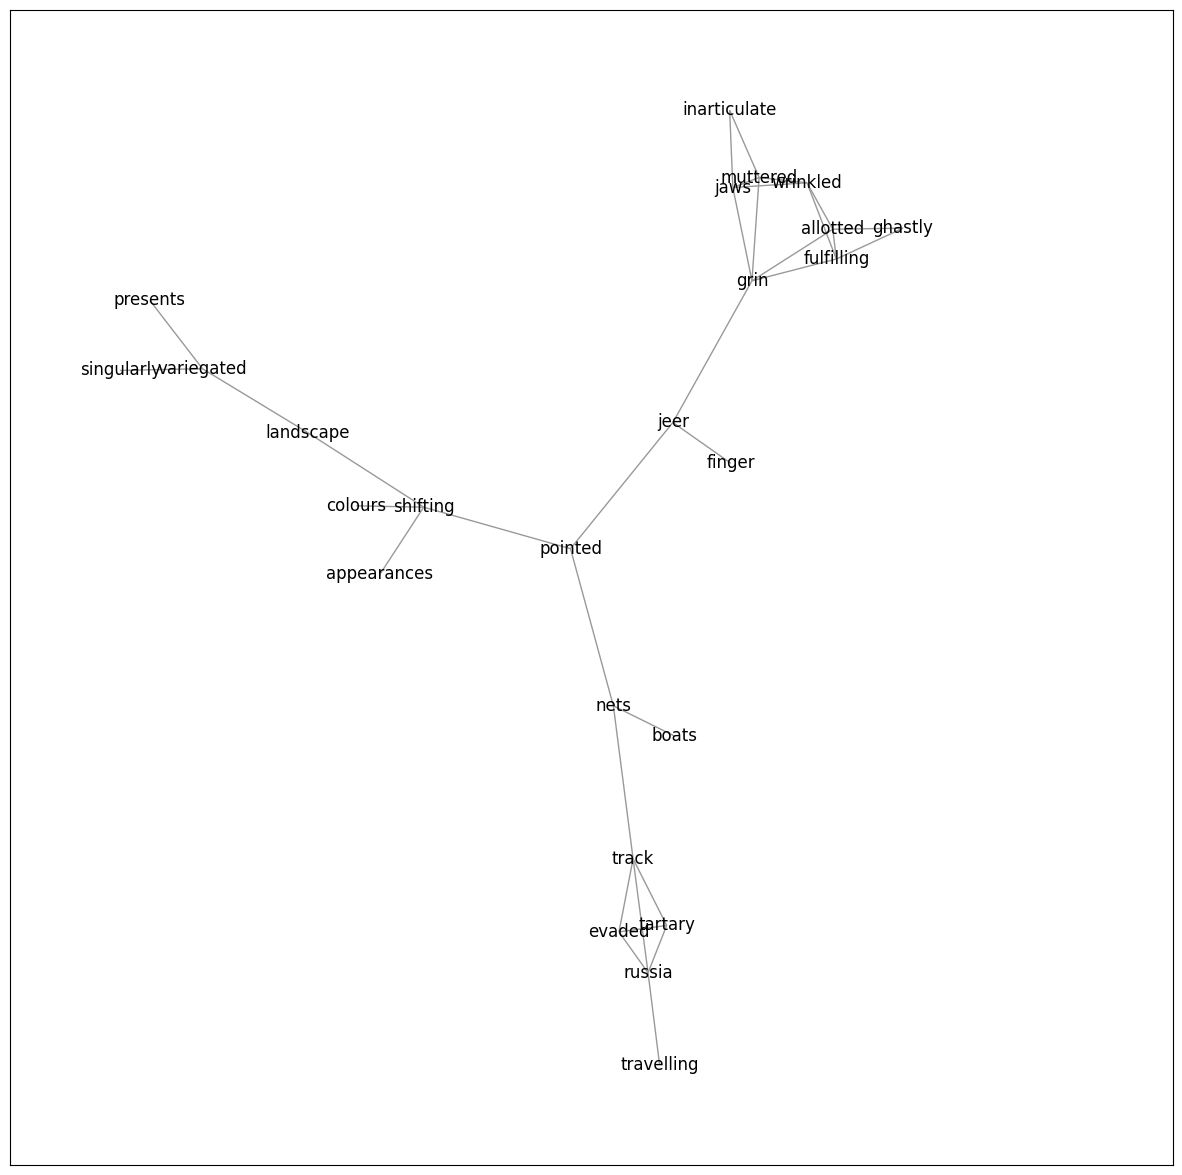

In [21]:

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G, pos=pos)
nx.draw_networkx(
    G, pos=pos, node_size=0, edge_color='#999999', with_labels=True)
# Add margin for labels
plt.xlim([-1.1, 1.1])